In [31]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

## Cria dataframes

In [32]:
transfers_df= pd.read_csv('./transfers.csv')

In [33]:
# Substituir 'transfer_fee' por 'market_value_in_eur' onde 'transfer_fee' é 0.0
transfers_df['transfer_fee'] = transfers_df.apply(
    lambda row: row['market_value_in_eur'] if row['transfer_fee'] == 0.0 else row['transfer_fee'], axis=1
)

# Verificar as mudanças
print(transfers_df.head().to_string())

   player_id transfer_date transfer_season  from_club_id  to_club_id  from_club_name     to_club_name  transfer_fee  market_value_in_eur      player_name
0     195778    2026-06-30           25/26            79          27   VfB Stuttgart    Bayern Munich    12000000.0           12000000.0  Alexander Nübel
1     569033    2026-06-30           25/26            39          27  1.FSV Mainz 05    Bayern Munich     4000000.0            4000000.0     Armindo Sieb
2     626913    2026-06-30           25/26           398         380           Lazio      Salernitana    10000000.0           10000000.0      Boulaye Dia
3    1047109    2026-06-30           25/26          2672         265  APO Levadiakos    Panathinaikos      100000.0             100000.0  Georgios Katris
4     360791    2025-12-31           25/26          6418        1030     Panetolikos  Argentinos Jrs.     1200000.0            1200000.0     Lucas Chaves




##Primeiro Grafo: Nós de jogadores e clubes, arestas do jogador para o clube destino



In [34]:
transfers_sample = transfers_df.head(60)

# Primeiro Grafo: Nós de jogadores e clubes, arestas do jogador para o clube destino
G1 = nx.DiGraph()

for idx, row in transfers_sample.iterrows():
    jogador = row['player_name']
    clube_destino = row['to_club_name']
    G1.add_node(jogador, tipo='jogador')
    G1.add_node(clube_destino, tipo='clube')
    G1.add_edge(jogador, clube_destino, transfer_fee=row['transfer_fee'])

# Verificar se as arestas foram adicionadas
print("G1 tem", G1.number_of_nodes(), "nós e", G1.number_of_edges(), "arestas.")


G1 tem 102 nós e 60 arestas.


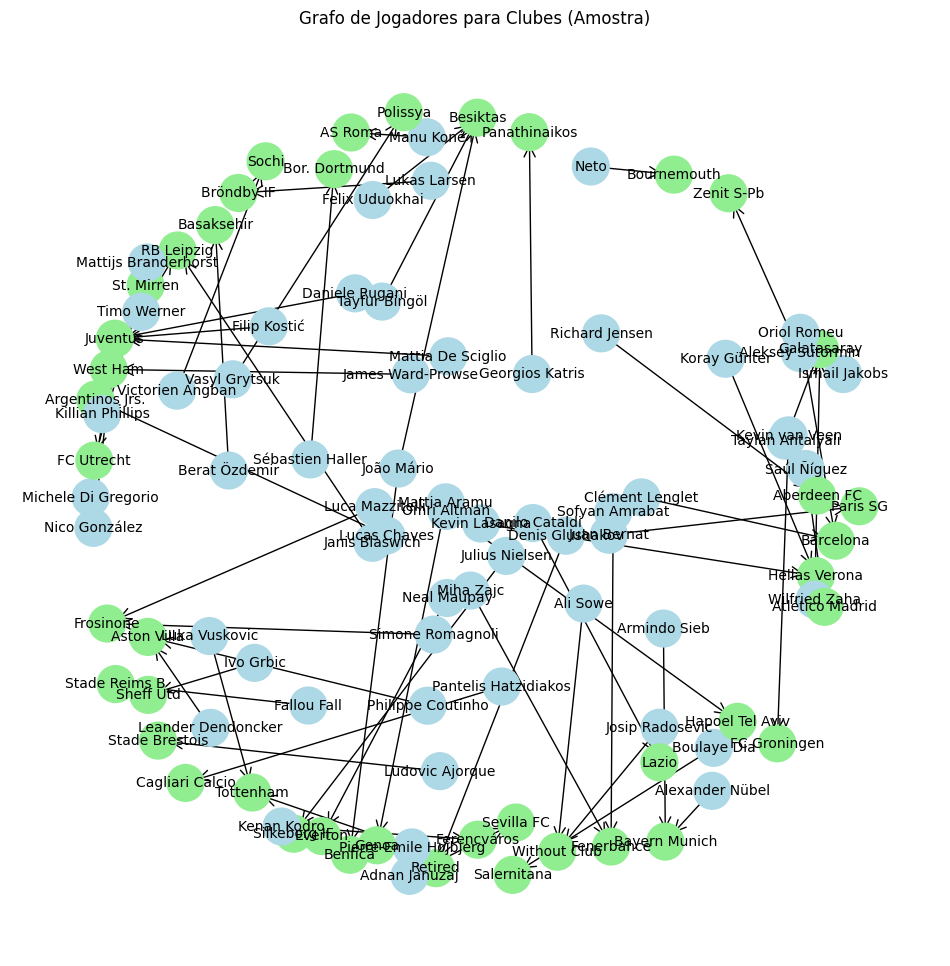

In [35]:
# Visualização do primeiro grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G1, k=0.5, iterations=50)

# Desenhar nós com cores diferentes para jogadores e clubes
node_colors = []
for node in G1.nodes():
    if G1.nodes[node]['tipo'] == 'jogador':
        node_colors.append('lightblue')
    else:
        node_colors.append('lightgreen')

nx.draw_networkx_nodes(G1, pos, node_size=700, node_color=node_colors)

# Desenhar arestas com setas
nx.draw_networkx_edges(G1, pos, arrowstyle='->', arrowsize=20)

# Desenhar labels
nx.draw_networkx_labels(G1, pos, font_size=10)

plt.title('Grafo de Jogadores para Clubes (Amostra)')
plt.axis('off')
plt.show()

##Segundo Grafo: Nós são clubes, arestas do clube de origem para o clube destino

####Visualização do subgrafo

In [36]:
# Segundo Grafo: Nós são clubes, arestas do clube de origem para o clube destino
# Contar o número de transferências entre clubes

edge_data = transfers_df.groupby(['from_club_name', 'to_club_name']).size().reset_index(name='transfer_count')

G2 = nx.DiGraph()

for idx, row in edge_data.iterrows():
    clube_origem = row['from_club_name']
    clube_destino = row['to_club_name']
    transfer_count = row['transfer_count']
    G2.add_node(clube_origem)
    G2.add_node(clube_destino)
    G2.add_edge(clube_origem, clube_destino, weight=transfer_count)

# Encontrar a região mais conectada do grafo
# Como o grafo é direcionado, usaremos componentes fracamente conectados
components = list(nx.weakly_connected_components(G2))

# Ordenar os componentes pelo tamanho (número de nós)
components.sort(key=len, reverse=True)

# Selecionar o maior componente conectado
largest_component = components[0]

# Criar um subgrafo a partir do maior componente conectado
G2_subgraph = G2.subgraph(largest_component).copy()

# Se o subgrafo tiver mais de 50 clubes, selecionar os mais conectados
if len(G2_subgraph.nodes) > 50:
    # Calcular o grau total (entrada + saída) de cada nó
    degrees = G2_subgraph.degree()
    # Ordenar os nós pelo grau
    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)
    # Selecionar os nós com maior grau
    top_nodes = [node for node, degree in sorted_nodes[2:12]]
    # Criar o subgrafo com os 50 nós mais conectados
    G2_subgraph = G2_subgraph.subgraph(top_nodes).copy()

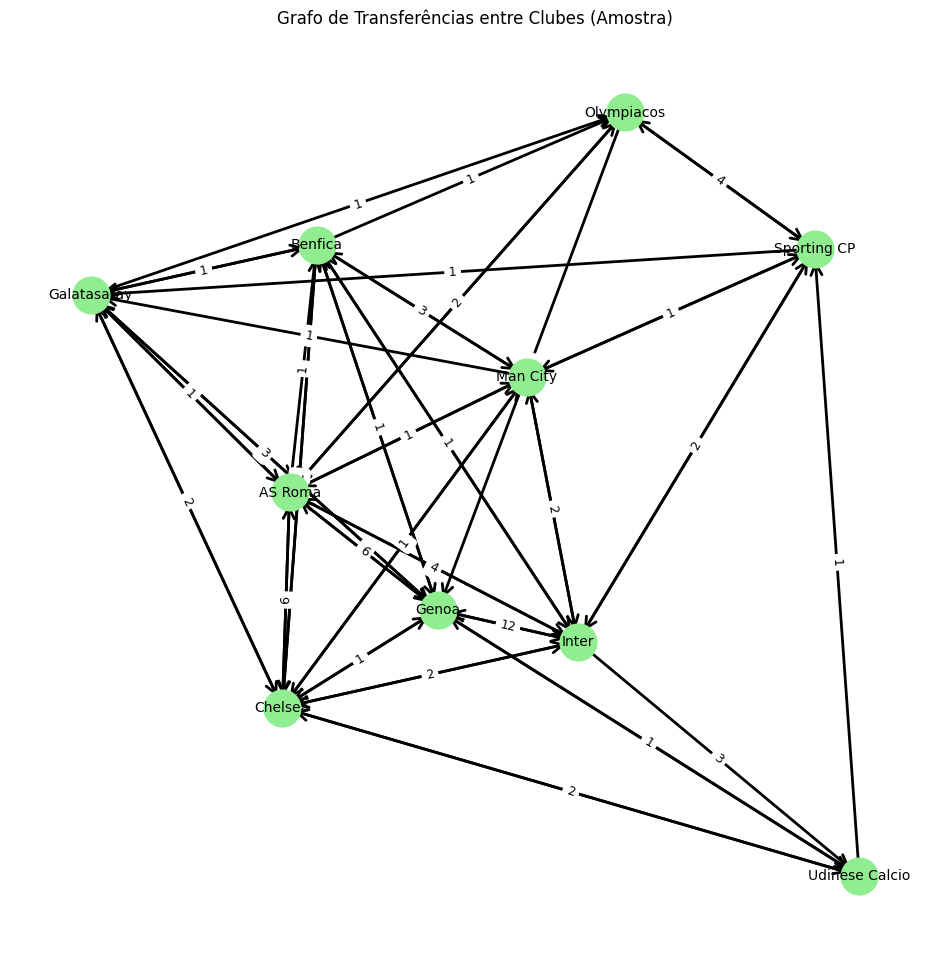

In [37]:
# Visualização do subgrafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G2_subgraph, k=0.5, iterations=50)

nx.draw_networkx_nodes(G2_subgraph, pos, node_size=700, node_color='lightgreen')
nx.draw_networkx_edges(G2_subgraph, pos, arrowstyle='->', arrowsize=20, width=2)
nx.draw_networkx_labels(G2_subgraph, pos, font_size=10)

# Adicionar os pesos (número de transferências) como rótulos nas arestas
edge_labels = nx.get_edge_attributes(G2_subgraph, 'weight')
formatted_edge_labels = {(u, v): f"{d}" for (u, v), d in edge_labels.items()}

nx.draw_networkx_edge_labels(G2_subgraph, pos, edge_labels=formatted_edge_labels, font_size=9, label_pos=0.5)

plt.title('Grafo de Transferências entre Clubes (Amostra)')
plt.axis('off')
plt.show()

### Centralidade e comunidades

In [38]:
# Construir o grafo G2: Nós são clubes, arestas do clube de origem para o clube destino
# Contar o número de transferências entre clubes
edge_data = transfers_df.groupby(['from_club_name', 'to_club_name']).size().reset_index(name='transfer_count')

G2 = nx.DiGraph()

for idx, row in edge_data.iterrows():
    clube_origem = row['from_club_name']
    clube_destino = row['to_club_name']
    transfer_count = row['transfer_count']
    G2.add_edge(clube_origem, clube_destino, weight=transfer_count)



# Encontrar o maior componente conectado (para grafos direcionados, usamos componentes fracamente conectados)
largest_component = max(nx.weakly_connected_components(G2), key=len)
G2_largest = G2.subgraph(largest_component).copy()

degrees = G2_largest.degree()
sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
top_clubs = [node for node, degree in sorted_degrees[2:10081]]

# Criar o subgrafo com os 100 clubes mais conectados
G2_subgraph = G2_largest.subgraph(top_clubs).copy()

In [39]:
# Calcular o in-degree e out-degree
in_degrees = dict(G2.in_degree())
out_degrees = dict(G2.out_degree())

# Converter para DataFrame para facilitar a visualização
degree_df = pd.DataFrame({
    'Club': list(G2_subgraph.nodes()),
    'In-Degree': [in_degrees[node] for node in G2_subgraph.nodes()],
    'Out-Degree': [out_degrees[node] for node in G2_subgraph.nodes()]
})

# Ordenar os clubes por In-Degree (maiores compradores)
top_buyers = degree_df.sort_values(by='In-Degree', ascending=False).head(10)
print("Top 10 Clubes Compradores (In-Degree):")
print(top_buyers[['Club', 'In-Degree']])

# Ordenar os clubes por Out-Degree (maiores vendedores)
top_sellers = degree_df.sort_values(by='Out-Degree', ascending=False).head(10)
print("\nTop 10 Clubes Vendedores (Out-Degree):")
print(top_sellers[['Club', 'Out-Degree']])

Top 10 Clubes Compradores (In-Degree):
               Club  In-Degree
43       Olympiacos        140
136         Benfica        128
427           Inter        128
400         AS Roma        123
148           Genoa        121
87   Udinese Calcio        120
413         Chelsea        117
218     Galatasaray        115
70    Hellas Verona        112
165     Sporting CP        110

Top 10 Clubes Vendedores (Out-Degree):
                Club  Out-Degree
43        Olympiacos         126
136          Benfica         124
427            Inter         114
400          AS Roma         108
165      Sporting CP         105
1078        Man City          98
413          Chelsea          97
83    Standard Liège          96
148            Genoa          96
464           Wolves          92


In [44]:
# Filtrar transferências com taxas de transferência conhecidas e criar uma cópia
transfers_with_fees = transfers_df.dropna(subset=['transfer_fee', 'from_club_name', 'to_club_name']).copy()

# Converter 'transfer_fee' para numérico
transfers_with_fees['transfer_fee'] = pd.to_numeric(transfers_with_fees['transfer_fee'], errors='coerce')

# Remover transferências com taxas não numéricas ou negativas
transfers_with_fees = transfers_with_fees[
    transfers_with_fees['transfer_fee'].notnull() & (transfers_with_fees['transfer_fee'] >= 0)
].copy()

# Calcular o total recebido por cada clube pelas vendas de jogadores
total_vendas = transfers_with_fees.groupby('from_club_name')['transfer_fee'].sum().reset_index()
total_vendas.rename(columns={'transfer_fee': 'Total Vendas'}, inplace=True)

# Calcular o total gasto por cada clube nas compras de jogadores
total_compras = transfers_with_fees.groupby('to_club_name')['transfer_fee'].sum().reset_index()
total_compras.rename(columns={'transfer_fee': 'Total Compras'}, inplace=True)

# Combinar os totais de vendas e compras em um único DataFrame
lucro_transferencias = pd.merge(
    total_vendas, total_compras,
    left_on='from_club_name', right_on='to_club_name',
    how='outer'
)

# Preencher valores NaN com zero
lucro_transferencias['Total Vendas'] = lucro_transferencias['Total Vendas'].fillna(0)
lucro_transferencias['Total Compras'] = lucro_transferencias['Total Compras'].fillna(0)

# Substituir NaN no nome dos clubes
lucro_transferencias['from_club_name'] = lucro_transferencias['from_club_name'].fillna(lucro_transferencias['to_club_name'])
lucro_transferencias['to_club_name'] = lucro_transferencias['to_club_name'].fillna(lucro_transferencias['from_club_name'])

# Calcular o lucro líquido
lucro_transferencias['Lucro'] = lucro_transferencias['Total Vendas'] - lucro_transferencias['Total Compras']

# Selecionar as colunas relevantes
lucro_transferencias = lucro_transferencias[['from_club_name', 'Total Vendas', 'Total Compras', 'Lucro']]

# Renomear a coluna 'from_club_name' para 'Clube' sem o uso de inplace=True
lucro_transferencias = lucro_transferencias.rename(columns={'from_club_name': 'Clube'})

# Ordenar os clubes por lucro
top_lucrativos = lucro_transferencias.sort_values(by='Lucro', ascending=False).head(10)

print("\nTop 10 Clubes que Mais Lucraram com Transferências:")
print(top_lucrativos[['Clube', 'Lucro']])


Top 10 Clubes que Mais Lucraram com Transferências:
               Clube        Lucro
556          Benfica  555700000.0
180             Ajax  514110000.0
1340        FC Porto  451920000.0
2947     RB Salzburg  397640000.0
3438     Sporting CP  372917000.0
2137      LOSC Lille  319930000.0
2687  Olympique Lyon  289380000.0
1062   Dinamo Zagreb  215255000.0
1126    E. Frankfurt  214900000.0
3074     River Plate  210169000.0


In [45]:
# Calcular a centralidade de intermediação
betweenness_centrality = nx.betweenness_centrality(G2_subgraph, weight='weight', normalized=True)

# Converter para DataFrame
betweenness_df = pd.DataFrame({
    'Club': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values())
})

# Ordenar os clubes por centralidade de intermediação
top_intermediaries = betweenness_df.sort_values(by='Betweenness Centrality', ascending=False).head(10)
print("\nTop 10 Clubes Intermediários (Betweenness Centrality):")
print(top_intermediaries)


Top 10 Clubes Intermediários (Betweenness Centrality):
                  Club  Betweenness Centrality
573    Go Ahead Eagles                0.018378
1341     Sporting Yth.                0.016833
1950   FC Twente Youth                0.016444
2632         Juventude                0.016001
5323         Esportivo                0.015579
936        Benfica U17                0.015421
5507     Juventude U20                0.015421
3282       Benfica U19                0.015045
960   Waasland-Beveren                0.014440
517        Ajax Youth                 0.013211


In [46]:
# Ordenar os clubes por centralidade de intermediação
top_intermediaries = betweenness_df.sort_values(by='Betweenness Centrality', ascending=False).head(30)
print("\nTop 10 Clubes Intermediários (Betweenness Centrality):")
print(top_intermediaries)


Top 10 Clubes Intermediários (Betweenness Centrality):
                  Club  Betweenness Centrality
573    Go Ahead Eagles                0.018378
1341     Sporting Yth.                0.016833
1950   FC Twente Youth                0.016444
2632         Juventude                0.016001
5323         Esportivo                0.015579
936        Benfica U17                0.015421
5507     Juventude U20                0.015421
3282       Benfica U19                0.015045
960   Waasland-Beveren                0.014440
517        Ajax Youth                 0.013211
1528       Barça Youth                0.012919
2469     Arsenal Youth                0.012711
1141     Chelsea Youth                0.012233
4144        Granollers                0.010847
2155    KRC Genk Youth                0.010242
115           Vejle BK                0.010139
43          Olympiacos                0.009502
796        CSKA Moscow                0.009487
2390   Vitória Setúbal                0.009439
1397

In [15]:
# Importar o módulo de detecção de comunidades corretamente
from community import community_louvain

# Carregar os dados
transfers_df = pd.read_csv('./transfers.csv')

# Substituir 'transfer_fee' por 'market_value_in_eur' onde 'transfer_fee' é 0.0
transfers_df['transfer_fee'] = transfers_df.apply(
    lambda row: row['market_value_in_eur'] if row['transfer_fee'] == 0.0 else row['transfer_fee'], axis=1
)

# Construir o grafo G2: Nós são clubes, arestas do clube de origem para o clube destino
# Contar o número de transferências entre clubes
edge_data = transfers_df.groupby(['from_club_name', 'to_club_name']).size().reset_index(name='transfer_count')

G2 = nx.DiGraph()

for idx, row in edge_data.iterrows():
    clube_origem = row['from_club_name']
    clube_destino = row['to_club_name']
    transfer_count = row['transfer_count']
    G2.add_edge(clube_origem, clube_destino, weight=transfer_count)

# Encontrar o maior componente conectado (para grafos direcionados, usamos componentes fracamente conectados)
largest_component = max(nx.weakly_connected_components(G2), key=len)
G2_largest = G2.subgraph(largest_component).copy()

# Selecionar os 100 clubes mais conectados (com base no grau total)
degrees = G2_largest.degree()
sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
top_100_clubs = [node for node, degree in sorted_degrees[2:10081]]

# Criar o subgrafo com os 100 clubes mais conectados
G2_subgraph = G2_largest.subgraph(top_100_clubs).copy()

# Converter o grafo para não direcionado para usar o algoritmo Louvain
G2_undirected = G2_subgraph.to_undirected()

# Aplicar o algoritmo de Louvain
partition = community_louvain.best_partition(G2_undirected, weight='weight')

# Adicionar a informação de comunidade aos nós
nx.set_node_attributes(G2_subgraph, partition, 'community')

# Contar o número de comunidades
num_communities = len(set(partition.values()))
print(f"\nNúmero de Comunidades Detectadas: {num_communities}")

# Exibir as comunidades
community_df = pd.DataFrame({
    'Club': list(partition.keys()),
    'Community': list(partition.values())
})

# Exibir os clubes pertencentes a cada comunidade
for i in range(num_communities):
    clubs_in_community = community_df[community_df['Community'] == i]['Club'].tolist()
    print(f"\nComunidade {i+1}: {clubs_in_community}")

# # Visualização das Comunidades
# import matplotlib.cm as cm
# import numpy as np

# # Mapear cores para cada comunidade
# communities = set(partition.values())
# colors = cm.rainbow(np.linspace(0, 1, len(communities)))
# community_colors = {community: colors[i] for i, community in enumerate(communities)}
# node_colors = [community_colors[partition[node]] for node in G2_subgraph.nodes()]

# # Desenhar o grafo com os nós coloridos por comunidade
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G2_subgraph, k=0.5, iterations=50)
# nx.draw_networkx_nodes(G2_subgraph, pos, node_size=50, node_color=node_colors)
# nx.draw_networkx_edges(G2_subgraph, pos, arrowstyle='->', arrowsize=5, width=0.1)
# nx.draw_networkx_labels(G2_subgraph, pos, font_size=8)
# plt.title('Comunidades Detectadas no Grafo de Transferências entre Clubes')
# plt.axis('off')
# plt.show()


Número de Comunidades Detectadas: 64

Comunidade 1: [' DYuSSh Zvezda', 'Akademia Zenit', 'Mlada Boleslav', 'A. Kursk Youth', 'Ak.Loko U16', 'Dynamo Moscow', 'Zenit S-Pb', 'FC Astana', 'Pari NN', 'Akhmat Grozny', 'FC Sheriff', 'Loko Moscow', 'Rubin Kazan', 'AF Shebekino', 'Salyut Belgorod', 'AF Volgar ', 'Anzhi U19', 'UOR-5 U16', 'Daejeon Citizen', 'CSKA Moscow', 'Krasnodar', 'Spartak Moscow', 'Ordabasy', 'FC Saxan', 'Terek Grozny', 'Khimki', 'Ufa', 'Rostov', 'Academia Akron', 'Konoplev U16', 'Academia FK', 'Ak. Zenit U16', 'Akademia Dynamo', 'FK Sochi II', 'Astra Giurgiu', 'Admiralteets', 'Rusj S-Pb', 'Afips Afipskiy', 'Chernomorets N.', 'Krasnodar 2', 'Shinnik Yaroslav', 'Ak. Dimitrovgrad', 'FC Togliatti', 'Ak. Dinamo U16', 'Dynamo 2 ', 'Dynamo M II', 'Fakel II', 'Ak. Rubin U16', 'Akademia Rubin ', 'SShOR Zenit', 'Zenit II', 'Ak.Cherta U16', 'Ak.ZSKA U16', 'Akad Chertanovo', 'FShM U16', 'KS Samara II', 'YM - Torpedo', 'Ak.Konoplev U17', 'Akron Konoplev', 'Akademia Loko', 'Akademia Ro


Número de Comunidades Detectadas: 4

Comunidade 1: ['Brentford', 'Sevilla FC', 'Tottenham', 'Galatasaray', 'OGC Nice', 'Fenerbahce']

Comunidade 2: ['E. Frankfurt', 'Olympiacos', 'Paris SG', 'Besiktas', 'Standard Liège', 'Club Brugge', 'Everton', 'SC Braga', 'Sporting CP', 'Liverpool', 'FC Porto', 'Man Utd', 'Nottm Forest']

Comunidade 3: ['LOSC Lille', 'PAOK Salonika', 'Wolves', 'Arsenal', 'Monaco', 'Brighton', 'Atlético Madrid', 'Trabzonspor', 'Chelsea', 'Celtic', 'Benfica', 'Shakhtar D.', 'KRC Genk', 'RSC Anderlecht', 'Newcastle', 'Man City', 'VfL Wolfsburg']

Comunidade 4: ['Fiorentina', 'Lazio', 'Udinese Calcio', 'AS Roma', 'Torino', 'SSC Napoli', 'Genoa', 'Hellas Verona', 'Inter', 'Atalanta BC', 'AC Milan', 'Juventus']


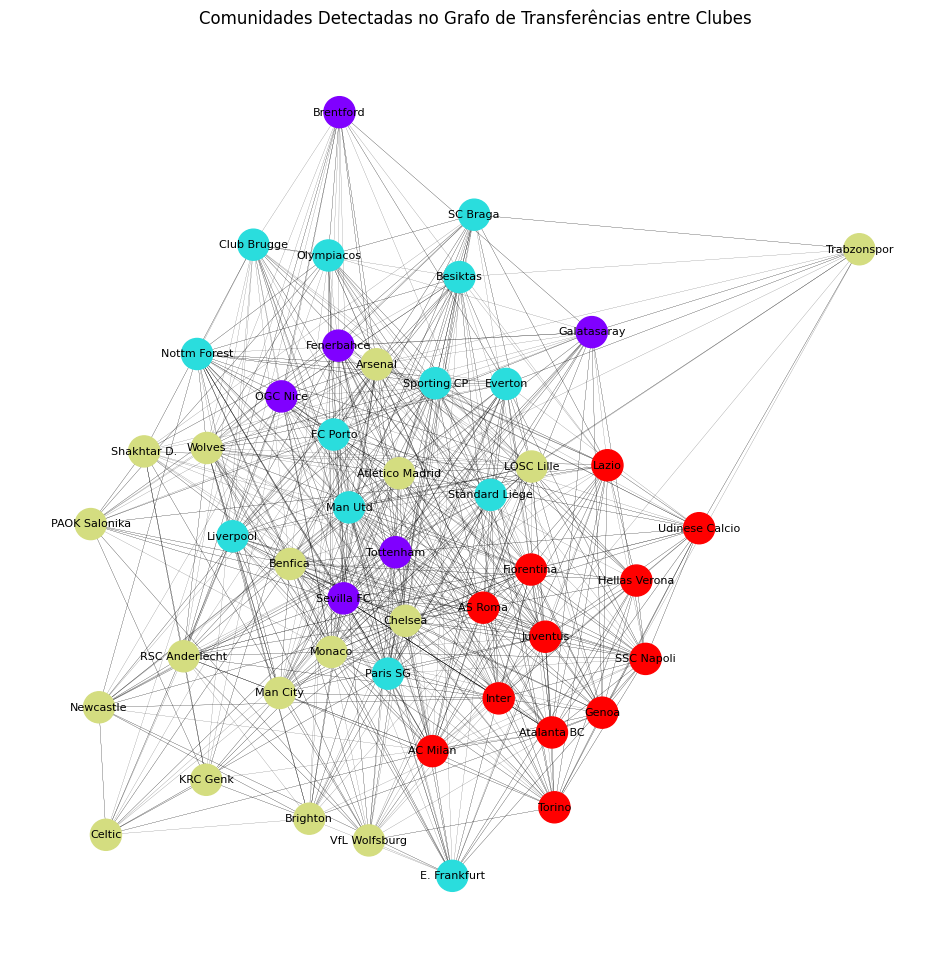

In [18]:
# Importar o módulo de detecção de comunidades corretamente
from community import community_louvain

# Carregar os dados
transfers_df = pd.read_csv('./transfers.csv')

# Substituir 'transfer_fee' por 'market_value_in_eur' onde 'transfer_fee' é 0.0
transfers_df['transfer_fee'] = transfers_df.apply(
    lambda row: row['market_value_in_eur'] if row['transfer_fee'] == 0.0 else row['transfer_fee'], axis=1
)

# Construir o grafo G2: Nós são clubes, arestas do clube de origem para o clube destino
# Contar o número de transferências entre clubes
edge_data = transfers_df.groupby(['from_club_name', 'to_club_name']).size().reset_index(name='transfer_count')

G2 = nx.DiGraph()

for idx, row in edge_data.iterrows():
    clube_origem = row['from_club_name']
    clube_destino = row['to_club_name']
    transfer_count = row['transfer_count']
    G2.add_edge(clube_origem, clube_destino, weight=transfer_count)

# Encontrar o maior componente conectado (para grafos direcionados, usamos componentes fracamente conectados)
largest_component = max(nx.weakly_connected_components(G2), key=len)
G2_largest = G2.subgraph(largest_component).copy()

# Selecionar os clubes mais conectados (com base no grau total)
degrees = G2_largest.degree()
sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
top_clubs = [node for node, degree in sorted_degrees[2:50]]

# Criar o subgrafo com os 100 clubes mais conectados
G2_subgraph = G2_largest.subgraph(top_clubs).copy()

# Converter o grafo para não direcionado para usar o algoritmo Louvain
G2_undirected = G2_subgraph.to_undirected()

# Aplicar o algoritmo de Louvain
partition = community_louvain.best_partition(G2_undirected, weight='weight')

# Adicionar a informação de comunidade aos nós
nx.set_node_attributes(G2_subgraph, partition, 'community')

# Contar o número de comunidades
num_communities = len(set(partition.values()))
print(f"\nNúmero de Comunidades Detectadas: {num_communities}")

# Exibir as comunidades
community_df = pd.DataFrame({
    'Club': list(partition.keys()),
    'Community': list(partition.values())
})

# Exibir os clubes pertencentes a cada comunidade
for i in range(num_communities):
    clubs_in_community = community_df[community_df['Community'] == i]['Club'].tolist()
    print(f"\nComunidade {i+1}: {clubs_in_community}")

# Visualização das Comunidades
import matplotlib.cm as cm
import numpy as np

# Mapear cores para cada comunidade
communities = set(partition.values())
colors = cm.rainbow(np.linspace(0, 1, len(communities)))
community_colors = {community: colors[i] for i, community in enumerate(communities)}
node_colors = [community_colors[partition[node]] for node in G2_subgraph.nodes()]

# Desenhar o grafo com os nós coloridos por comunidade
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G2_subgraph, k=0.5, iterations=50)
nx.draw_networkx_nodes(G2_subgraph, pos, node_size=500, node_color=node_colors)
nx.draw_networkx_edges(G2_subgraph, pos, arrowstyle='->', arrowsize=5, width=0.1)
nx.draw_networkx_labels(G2_subgraph, pos, font_size=8)
plt.title('Comunidades Detectadas no Grafo de Transferências entre Clubes')
plt.axis('off')
plt.show()